In [1]:
import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn import linear_model
from sklearn.model_selection import KFold, train_test_split

# Data gathering

In [2]:
train_set = pd.read_csv('data/train.csv')
train_set[train_set['cfips']==4012]

,row_id,cfips,county,state,first_day_of_month,microbusiness_density,active
3900,4012_2019-08-01,4012,La Paz County,Arizona,2019-08-01,2.336202,399
3901,4012_2019-09-01,4012,La Paz County,Arizona,2019-09-01,2.301071,393
3902,4012_2019-10-01,4012,La Paz County,Arizona,2019-10-01,2.330347,398
3903,4012_2019-11-01,4012,La Paz County,Arizona,2019-11-01,2.330347,398
3904,4012_2019-12-01,4012,La Paz County,Arizona,2019-12-01,2.330347,398
3905,4012_2020-01-01,4012,La Paz County,Arizona,2020-01-01,2.319528,401
3906,4012_2020-02-01,4012,La Paz County,Arizona,2020-02-01,2.325312,402
3907,4012_2020-03-01,4012,La Paz County,Arizona,2020-03-01,2.325312,402
3908,4012_2020-04-01,4012,La Paz County,Arizona,2020-04-01,2.360018,408
3909,4012_2020-05-01,4012,La Paz County,Arizona,2020-05-01,2.516196,435


In [3]:
train_set.head()

,row_id,cfips,county,state,first_day_of_month,microbusiness_density,active
0,1001_2019-08-01,1001,Autauga County,Alabama,2019-08-01,3.007682,1249
1,1001_2019-09-01,1001,Autauga County,Alabama,2019-09-01,2.884870,1198
2,1001_2019-10-01,1001,Autauga County,Alabama,2019-10-01,3.055843,1269
3,1001_2019-11-01,1001,Autauga County,Alabama,2019-11-01,2.993233,1243
4,1001_2019-12-01,1001,Autauga County,Alabama,2019-12-01,2.993233,1243


In [4]:
train_set.dtypes

row_id                    object
cfips                      int64
county                    object
state                     object
first_day_of_month        object
microbusiness_density    float64
active                     int64
dtype: object

In [5]:
train_set.describe()

,cfips,microbusiness_density,active
count,122265.000000,122265.000000,1.222650e+05
mean,30376.037640,3.817671,6.442858e+03
std,15143.508721,4.991087,3.304001e+04
min,1001.000000,0.000000,0.000000e+00
25%,18177.000000,1.639344,1.450000e+02
50%,29173.000000,2.586543,4.880000e+02
75%,45077.000000,4.519231,2.124000e+03
max,56045.000000,284.340030,1.167744e+06


In [6]:
revealed_test = pd.read_csv('data/revealed_test.csv')
revealed_test.head()

,row_id,cfips,county,state,first_day_of_month,microbusiness_density,active
0,1001_2022-11-01,1001,Autauga County,Alabama,2022-11-01,3.442677,1463
1,1001_2022-12-01,1001,Autauga County,Alabama,2022-12-01,3.470915,1475
2,1003_2022-11-01,1003,Baldwin County,Alabama,2022-11-01,8.257636,14145
3,1003_2022-12-01,1003,Baldwin County,Alabama,2022-12-01,8.250630,14133
4,1005_2022-11-01,1005,Barbour County,Alabama,2022-11-01,1.247223,247


In [7]:
census_starter = pd.read_csv('data/census_starter.csv')
census_starter.head()

,pct_bb_2017,pct_bb_2018,pct_bb_2019,pct_bb_2020,pct_bb_2021,cfips,pct_college_2017,pct_college_2018,pct_college_2019,pct_college_2020,...,pct_it_workers_2017,pct_it_workers_2018,pct_it_workers_2019,pct_it_workers_2020,pct_it_workers_2021,median_hh_inc_2017,median_hh_inc_2018,median_hh_inc_2019,median_hh_inc_2020,median_hh_inc_2021
0,76.6,78.9,80.6,82.7,85.5,1001,14.5,15.9,16.1,16.7,...,1.3,1.1,0.7,0.6,1.1,55317,58786.0,58731,57982.0,62660.0
1,74.5,78.1,81.8,85.1,87.9,1003,20.4,20.7,21.0,20.2,...,1.4,1.3,1.4,1.0,1.3,52562,55962.0,58320,61756.0,64346.0
2,57.2,60.4,60.5,64.6,64.6,1005,7.6,7.8,7.6,7.3,...,0.5,0.3,0.8,1.1,0.8,33368,34186.0,32525,34990.0,36422.0
3,62.0,66.1,69.2,76.1,74.6,1007,8.1,7.6,6.5,7.4,...,1.2,1.4,1.6,1.7,2.1,43404,45340.0,47542,51721.0,54277.0
4,65.8,68.5,73.0,79.6,81.0,1009,8.7,8.1,8.6,8.9,...,1.3,1.4,0.9,1.1,0.9,47412,48695.0,49358,48922.0,52830.0


In [8]:
census_starter.describe()

,pct_bb_2017,pct_bb_2018,pct_bb_2019,pct_bb_2020,pct_bb_2021,cfips,pct_college_2017,pct_college_2018,pct_college_2019,pct_college_2020,...,pct_it_workers_2017,pct_it_workers_2018,pct_it_workers_2019,pct_it_workers_2020,pct_it_workers_2021,median_hh_inc_2017,median_hh_inc_2018,median_hh_inc_2019,median_hh_inc_2020,median_hh_inc_2021
count,3142.000000,3142.000000,3142.000000,3141.000000,3141.000000,3142.000000,3142.000000,3142.000000,3142.000000,3141.000000,...,3142.000000,3141.000000,3142.000000,3141.000000,3141.000000,3142.000000,3141.000000,3142.000000,3140.000000,3140.000000
mean,69.920401,72.690866,75.398600,78.543298,80.539096,30383.649268,13.813399,14.005379,14.240452,14.631328,...,1.427148,1.382171,1.338956,1.309265,1.272684,49754.163908,51583.175422,53475.909612,55012.443312,58223.339490
std,9.702052,9.255863,8.846665,8.250864,7.889931,15162.508374,5.586649,5.630199,5.689780,5.776940,...,0.986985,0.942777,0.940891,0.990342,0.968579,13154.424871,13703.502202,14192.529173,14649.568591,15541.038914
min,24.500000,25.700000,34.800000,33.300000,37.000000,1001.000000,2.400000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,19264.000000,20188.000000,21504.000000,22292.000000,17109.000000
25%,64.200000,67.425000,70.500000,74.100000,76.400000,18177.500000,9.700000,9.900000,10.100000,10.500000,...,0.800000,0.800000,0.700000,0.700000,0.600000,41123.000000,42480.000000,44155.000000,45653.000000,48179.500000
50%,70.700000,73.600000,76.450000,79.600000,81.700000,29176.000000,12.800000,13.000000,13.250000,13.600000,...,1.300000,1.300000,1.200000,1.200000,1.100000,48065.500000,49888.000000,51757.500000,52842.000000,55907.000000
75%,76.400000,78.800000,81.400000,84.100000,85.900000,45080.500000,16.800000,17.100000,17.300000,17.900000,...,1.900000,1.800000,1.800000,1.800000,1.700000,55763.500000,57611.000000,59867.250000,61500.750000,64930.000000
max,94.600000,95.500000,96.000000,97.100000,97.600000,56045.000000,43.700000,48.000000,45.400000,43.000000,...,17.400000,11.700000,10.500000,15.200000,15.200000,129588.000000,136268.000000,142299.000000,147111.000000,156821.000000


In [9]:
godaddy_1 = pd.read_csv('data/VF_indcom_bundle_Q222/VF_indcom_counties_Q222.csv')
godaddy_1.head()

,cfips,county,state,groupflag,total_pop_20,orders_rank_aug19,orders_rank_sep19,orders_rank_oct19,orders_rank_nov19,orders_rank_dec19,...,avg_traffic_oct21,avg_traffic_nov21,avg_traffic_dec21,avg_traffic_jan22,avg_traffic_feb22,avg_traffic_mar22,avg_traffic_apr22,avg_traffic_may22,avg_traffic_jun22,avg_lifespan_mths
0,1001.0,Autauga,AL,30k - 225k pop,55639.0,668.0,511.0,723.0,624.0,1023.0,...,419.1,455.9,480.9,663.0,629.7,647.6,435.2,415.0,398.9,12.4
1,1003.0,Baldwin,AL,30k - 225k pop,218289.0,804.0,780.0,831.0,899.0,705.0,...,124.2,113.1,108.1,126.7,125.9,135.4,134.5,145.8,152.9,13.9
2,1005.0,Barbour,AL,< 30k pop,25026.0,1001.0,684.0,883.0,1118.0,1159.0,...,157.8,111.6,110.6,133.8,114.5,129.9,153.3,134.6,139.7,15.1
3,1007.0,Bibb,AL,< 30k pop,22374.0,123.0,96.0,113.0,199.0,195.0,...,132.2,124.7,113.1,101.9,69.3,74.4,65.1,69.6,91.1,14.8
4,1009.0,Blount,AL,30k - 225k pop,57755.0,65.0,108.0,203.0,121.0,313.0,...,62.8,70.8,70.9,95.8,67.5,64.8,84.7,108.3,88.4,14.8


In [10]:
godaddy_2 = pd.read_csv('data/VF_indcom_bundle_Q422/VF_indcom_cfips_Q422.csv')
godaddy_2.head()

,cfips,county,state,groupflag,total_pop_20,orders_rank_aug19,orders_rank_sep19,orders_rank_oct19,orders_rank_nov19,orders_rank_dec19,...,top3industries_mar22,top3industries_apr22,top3industries_may22,top3industries_jun22,top3industries_jul22,top3industries_aug22,top3industries_sep22,top3industries_oct22,top3industries_nov22,top3industries_dec22
0,1001.0,Autauga,AL,30k - 225k pop,55639.0,668.0,511.0,723.0,624.0,1023.0,...,"fashion, beauty, fitness_wellness","fashion, beauty, restaurant","fashion, beauty, restaurant","fashion, beauty, realestate","fashion, beauty, realestate","fashion, charity_or_pol, realestate","fashion, realestate, retail","fashion, retail, sports","fashion, realestate, retail","fashion, retail, realestate"
1,1003.0,Baldwin,AL,30k - 225k pop,218289.0,804.0,780.0,831.0,899.0,705.0,...,"transportation, fashion, outdoors","fashion, restaurant, transportation","beauty, restaurant, transportation","beauty, restaurant, hobby","hobby, beauty, transportation","beauty, transportation, hobby","beauty, auto, transportation","auto, hobby, beauty","beauty, fitness_wellness, transportation","beauty, outdoors, transportation"
2,1005.0,Barbour,AL,< 30k pop,25026.0,1001.0,684.0,883.0,1118.0,1159.0,...,"homesvcs, personal",homesvcs,"events, fitness_wellness","artdesign, events","events, homesvcs","events, fitness_wellness","events, artdesign","fitness_wellness, health_med",homesvcs,"homesvcs, fashion, fitness_wellness"
3,1007.0,Bibb,AL,< 30k pop,22374.0,123.0,96.0,113.0,199.0,195.0,...,"health_med, beauty, fashion","beauty, fashion, health_med","homesvcs, beauty, health_med","homesvcs, beauty, health_med","beauty, health_med, fitness_wellness","beauty, fashion, health_med","beauty, fashion, retail","beauty, fashion, health_med","beauty, fashion, homedecor","homedecor, fashion, fitness_wellness"
4,1009.0,Blount,AL,30k - 225k pop,57755.0,65.0,108.0,203.0,121.0,313.0,...,"hobby, profsvcs, fashion","photography, beauty, profsvcs","homedecor, photography, profsvcs","photography, hobby, profsvcs","photography, profsvcs, artdesign","profsvcs, photography, beauty","profsvcs, music, artdesign","hobby, profsvcs, events","hobby, profsvcs, beauty","hobby, profsvcs, music"


In [11]:
godaddy_3 = pd.read_csv('data/all_indicators-all_data/private_employment_raw_in_thousands.csv')
godaddy_3.head()

,Geography,1990-01-01,1990-02-01,1990-03-01,1990-04-01,1990-05-01,1990-06-01,1990-07-01,1990-08-01,1990-09-01,...,2022-03-01,2022-04-01,2022-05-01,2022-06-01,2022-07-01,2022-08-01,2022-09-01,2022-10-01,2022-11-01,2022-12-01
0,United States,91048.0,91258.0,91350.0,91309.0,91240.0,91300.0,91264.0,91159.0,91081.0,...,128680.0,129048.0,129379.0,129725.0,130173.0,130406.0,130661.0,130880.0,131082.0,131302.0
1,Alabama,1310.5,1308.2,1305.6,1315.2,1316.8,1322.9,1317.9,1319.1,1318.3,...,1681.0,1680.9,1688.8,1687.8,1692.0,1699.3,1703.3,1706.4,1710.6,1713.1
2,Alaska,162.0,162.8,164.6,166.2,167.1,168.3,167.2,167.2,167.2,...,239.9,240.1,237.4,236.4,237.9,239.8,240.6,243.1,245.0,245.6
3,Arizona,1207.3,1208.2,1210.2,1213.6,1212.1,1213.3,1210.2,1209.7,1211.5,...,2622.9,2635.1,2641.4,2647.4,2669.0,2674.6,2680.0,2686.4,2687.6,2696.8
4,Arkansas,757.7,756.5,757.8,761.0,761.5,765.7,766.6,768.9,770.5,...,1100.1,1101.0,1096.6,1103.0,1115.2,1117.8,1114.6,1113.7,1112.0,1114.5


In [12]:
sample_submission = pd.read_csv('data/sample_submission.csv')
sample_submission.head()

,row_id,microbusiness_density
0,1001_2022-11-01,3.817671
1,1003_2022-11-01,3.817671
2,1005_2022-11-01,3.817671
3,1007_2022-11-01,3.817671
4,1009_2022-11-01,3.817671


# Building models

In [13]:
# Validation function
def smape(actual, forecast):
    numerator = np.abs(actual-forecast)
    denominator = (np.abs(actual) + np.abs(forecast))/2
    return 1/len(actual) * np.sum(numerator/denominator)

### Linear regression model

In [14]:
train_set.head()

,row_id,cfips,county,state,first_day_of_month,microbusiness_density,active
0,1001_2019-08-01,1001,Autauga County,Alabama,2019-08-01,3.007682,1249
1,1001_2019-09-01,1001,Autauga County,Alabama,2019-09-01,2.884870,1198
2,1001_2019-10-01,1001,Autauga County,Alabama,2019-10-01,3.055843,1269
3,1001_2019-11-01,1001,Autauga County,Alabama,2019-11-01,2.993233,1243
4,1001_2019-12-01,1001,Autauga County,Alabama,2019-12-01,2.993233,1243


### Basic linear regression - single row

SMAPE result: microbusiness_density    0.026439
dtype: float64


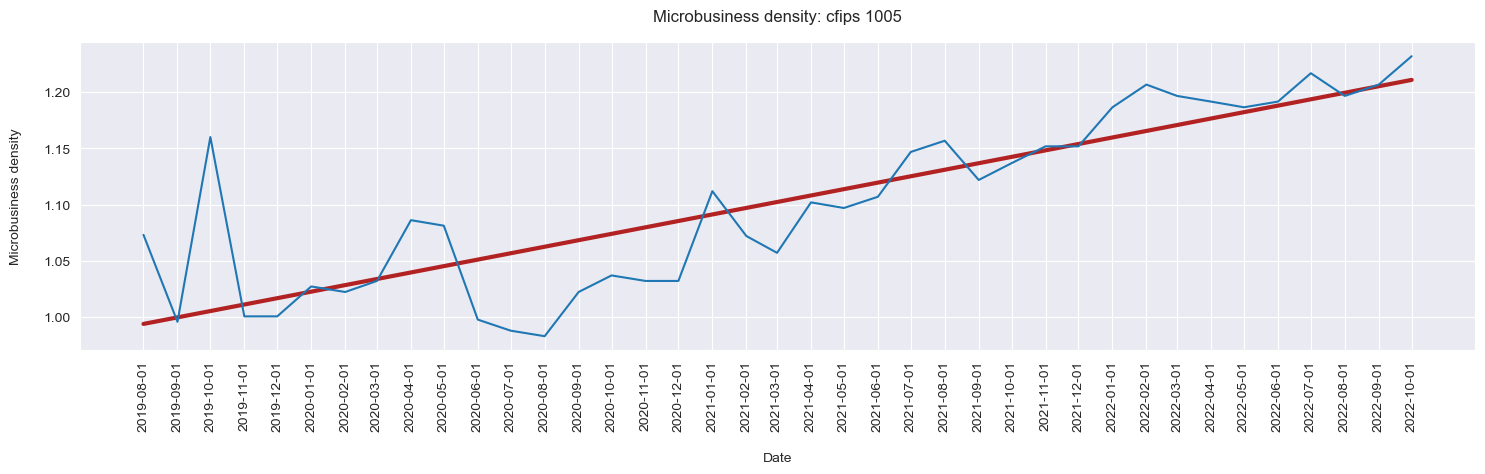

In [15]:
# Prepare data
cfips = 1005
lin_reg_df = train_set[train_set['cfips']==cfips][['first_day_of_month', 'microbusiness_density']]
lin_reg_df['time'] = [datetime.datetime.toordinal(x) for x in pd.to_datetime(lin_reg_df['first_day_of_month'])]
lin_reg_df['first_day_of_month'] = [datetime.datetime.strptime(x, '%Y-%m-%d').date() for x in lin_reg_df['first_day_of_month']]
lin_reg_df.head()

# Training data
lin_reg_X_train = lin_reg_df.loc[:, ['time']]
lin_reg_y_train = lin_reg_df.loc[:, ['microbusiness_density']]
lin_reg_model = linear_model.LinearRegression()
lin_reg_model.fit(lin_reg_X_train, lin_reg_y_train)

# Predicting
y_pred = lin_reg_model.predict(lin_reg_X_train)

# Storing predicted values
y_pred_df = lin_reg_X_train
y_pred_df['predicted'] = y_pred
y_pred_df['first_day_of_month'] = [datetime.datetime.fromordinal(x) for x in y_pred_df['time']]

# SMAPE
smape_result = smape(y_pred, lin_reg_y_train)
print(f'SMAPE result: {smape_result}')

# Plot
fig, ax = plt.subplots(figsize=(18, 4), squeeze=False)

sns.lineplot(
    data=y_pred_df,
    x='first_day_of_month',
    y='predicted',
    ax=ax[0, 0],
    color='firebrick',
    linewidth=3
)

sns.lineplot(
    data=lin_reg_df,
    x='first_day_of_month',
    y='microbusiness_density',
    ax=ax[0, 0]
)
ax[0, 0].set_title(f'Microbusiness density: cfips {cfips}', pad=15)
ax[0, 0].set_xlabel('Date', labelpad=15)
ax[0, 0].set_ylabel('Microbusiness density', labelpad=15)
ax[0, 0].tick_params(axis='x', rotation=90)
ax[0, 0].set_xticks(y_pred_df['first_day_of_month'])

plt.show()

### Linear regression with lag feature - single row

In [16]:
# Prepare data
cfips = 1005
lin_reg_lag_df = train_set[train_set['cfips']==cfips][['first_day_of_month', 'microbusiness_density']]
lin_reg_lag_df['time'] = [datetime.datetime.toordinal(x) for x in pd.to_datetime(lin_reg_lag_df['first_day_of_month'])]
lin_reg_lag_df['first_day_of_month'] = [datetime.datetime.strptime(x, '%Y-%m-%d').date() for x in lin_reg_lag_df['first_day_of_month']]
lin_reg_lag_df['microbusiness_density_lag'] = lin_reg_lag_df['microbusiness_density'].shift(1)
lin_reg_lag_df = lin_reg_lag_df.dropna()
lin_reg_lag_df.head()

# Prepare linear regression on data
lin_reg_lag_X_train = lin_reg_lag_df.loc[:, ['microbusiness_density_lag']]
lin_reg_lag_y_train = lin_reg_lag_df.loc[:, ['microbusiness_density']]
lin_reg_lag_model = linear_model.LinearRegression()
lin_reg_lag_model.fit(lin_reg_lag_X_train, lin_reg_lag_y_train)

# Predict data
y_pred_lag = lin_reg_lag_model.predict(lin_reg_lag_X_train)

# SMAPE
smape_result = smape(y_pred_lag, lin_reg_lag_y_train)
print(f'SMAPE result: {smape_result}')

# Store predicted data
y_pred_lag_df = lin_reg_lag_X_train
y_pred_lag_df['predicted'] = y_pred_lag
y_pred_lag_df['first_day_of_month'] = lin_reg_lag_df['first_day_of_month']
y_pred_lag_df.head()

SMAPE result: microbusiness_density    0.028808
dtype: float64


,microbusiness_density_lag,predicted,first_day_of_month
79,1.073138,1.081738,2019-09-01
80,0.995794,1.017548,2019-10-01
81,1.160149,1.153951,2019-11-01
82,1.000628,1.021560,2019-12-01
83,1.000628,1.021560,2020-01-01


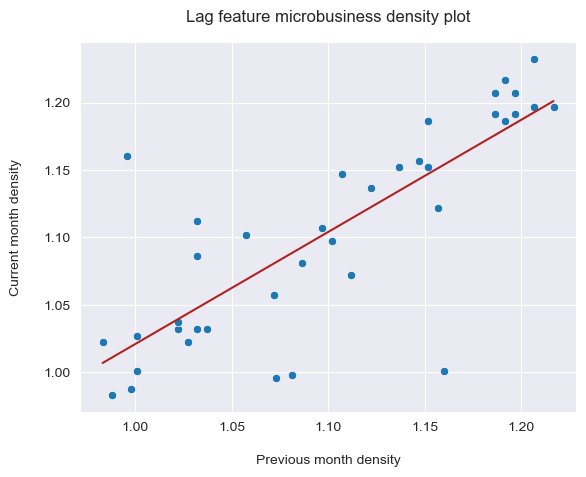

In [17]:
# Plot lag data
fig, ax = plt.subplots(squeeze=False)

sns.lineplot(
    data=y_pred_lag_df,
    x='microbusiness_density_lag',
    y='predicted',
    color='firebrick',
    ax=ax[0, 0]
)

sns.scatterplot(
    data=lin_reg_lag_df,
    x='microbusiness_density_lag',
    y='microbusiness_density',
    ax=ax[0, 0]
)
ax[0, 0].set_title('Lag feature microbusiness density plot', pad=15)
ax[0, 0].set_xlabel('Previous month density', labelpad=15)
ax[0, 0].set_ylabel('Current month density', labelpad=15)

plt.show()

**Conclusion:** From above we can see a strong relation between previous and current month data

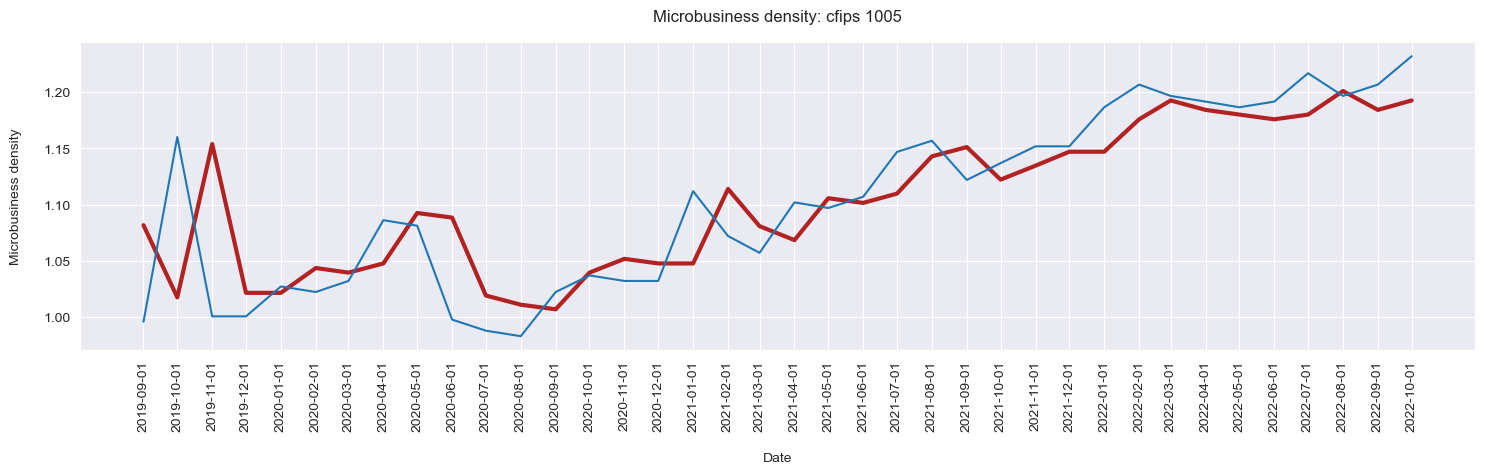

In [18]:
# Plot
fig, ax = plt.subplots(figsize=(18, 4), squeeze=False)

sns.lineplot(
    data=y_pred_lag_df,
    x='first_day_of_month',
    y='predicted',
    ax=ax[0, 0],
    color='firebrick',
    linewidth=3
)

sns.lineplot(
    data=lin_reg_lag_df,
    x='first_day_of_month',
    y='microbusiness_density',
    ax=ax[0, 0]
)
ax[0, 0].set_title(f'Microbusiness density: cfips {cfips}', pad=15)
ax[0, 0].set_xlabel('Date', labelpad=15)
ax[0, 0].set_ylabel('Microbusiness density', labelpad=15)
ax[0, 0].tick_params(axis='x', rotation=90)
ax[0, 0].set_xticks(y_pred_lag_df['first_day_of_month'])

plt.show()

**Conclusion:** even though the system looks more responsive to data changes, it gave worse SMAPE result.

## Linear regression with one parameter - prediction for 2022-12-01

In [19]:
# Test data
test_day = '2022-12-01'
lin_reg_y_test = revealed_test.loc[revealed_test['first_day_of_month'] == test_day, ['cfips', 'microbusiness_density']]
lin_reg_y_test.head()

,cfips,microbusiness_density
1,1001,3.470915
3,1003,8.250630
5,1005,1.252272
7,1007,1.287240
9,1009,1.852060


In [20]:
# Turn off SettingWithCopyWarning
pd.set_option('mode.chained_assignment', None)

# Prepare data
lin_reg_multiple_df = train_set[['cfips', 'first_day_of_month', 'microbusiness_density']]
lin_reg_multiple_df['first_day_of_month'] = pd.to_datetime(lin_reg_multiple_df['first_day_of_month']) # Convert from str to datetime
lin_reg_multiple_df['first_day_of_month'] = [datetime.datetime.toordinal(x) for x in lin_reg_multiple_df['first_day_of_month']] # Convert to ordinal value

# Create DataFrame to store predicted values
test_day_ordinal = datetime.datetime.toordinal(datetime.datetime.strptime(test_day, '%Y-%m-%d'))
predict_df = pd.DataFrame([test_day_ordinal], columns=['first_day_of_month'])
forecast_df_columns = ['row_id', 'microbusiness_density']
forecast_df = pd.DataFrame(columns=forecast_df_columns)

# Create model
lin_reg_multiple_model = linear_model.LinearRegression()

for cfips in lin_reg_multiple_df['cfips'].unique():
    lin_reg_multiple_X_train = lin_reg_multiple_df.loc[lin_reg_multiple_df['cfips']==cfips, ['first_day_of_month']]
    lin_reg_multiple_y_train = lin_reg_multiple_df.loc[lin_reg_multiple_df['cfips']==cfips, ['microbusiness_density']]
    lin_reg_multiple_model.fit(lin_reg_multiple_X_train, lin_reg_multiple_y_train)
    predicted_value = lin_reg_multiple_model.predict(predict_df)
    # This could look like below, but we get nasty "valid feature names" warning
    # predicted_value = lin_reg_multiple_model.predict([[test_day_ordinal]])
    row_id = f'{cfips}_{test_day}'
    predicted_microbusiness_density = predicted_value[0][0]
    forecast_df_values = {
        forecast_df_columns[0]: row_id,
        forecast_df_columns[1]: predicted_microbusiness_density
    }
    forecast_df = pd.concat([forecast_df, pd.DataFrame(forecast_df_values, index=[0])])

forecast_df = forecast_df.reset_index(drop=True)

In [21]:
forecast_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3135 entries, 0 to 3134
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   row_id                 3135 non-null   object 
 1   microbusiness_density  3135 non-null   float64
dtypes: float64(1), object(1)
memory usage: 49.1+ KB


### SMAPE score for linear regression with one parameter

In [22]:
# Calculate SMAPE result
smape(forecast_df['microbusiness_density'], lin_reg_y_test['microbusiness_density'])

0.38845722849429876

## Linear regression with multiple parameters

We will try to modify our training sets by adding a couple of parameters.

TODO: Gather more data, maybe perform feature selection, train and predict on multiple parameters model
Ridge regression
Lasso
Elastic net

In [59]:
# Test data
test_day = '2022-12-01'
lin_reg_y_test = revealed_test.loc[revealed_test['first_day_of_month'] == test_day, ['cfips', 'microbusiness_density']]

# Prepare data
lin_reg_multiparam_df = train_set[['cfips', 'state', 'first_day_of_month', 'microbusiness_density']]
lin_reg_multiparam_df['first_day_of_month_ordinal'] = pd.to_datetime(lin_reg_multiparam_df['first_day_of_month']) # Convert from str to datetime
lin_reg_multiparam_df['first_day_of_month_ordinal'] = [datetime.datetime.toordinal(x) for x in lin_reg_multiparam_df['first_day_of_month_ordinal']] # Convert to ordinal value

lin_reg_multiparam_df.head()

,cfips,state,first_day_of_month,microbusiness_density,first_day_of_month_ordinal
0,1001,Alabama,2019-08-01,3.007682,737272
1,1001,Alabama,2019-09-01,2.884870,737303
2,1001,Alabama,2019-10-01,3.055843,737333
3,1001,Alabama,2019-11-01,2.993233,737364
4,1001,Alabama,2019-12-01,2.993233,737394


In [44]:
# Create DF with additional data from csv files, containing several indicators for each state per month.
manufacturing_employment_data = pd.read_csv('data/all_indicators-all_data/manufacturing_employment_raw_in_thousands.csv')
private_employment_data = pd.read_csv('data/all_indicators-all_data/private_employment_raw_in_thousands.csv')
public_employment_data = pd.read_csv('data/all_indicators-all_data/public_employment_raw_in_thousands.csv')
retail_employment_data = pd.read_csv('data/all_indicators-all_data/retail_trade_employment_raw_in_thousands.csv')
total_employment_data = pd.read_csv('data/all_indicators-all_data/total_employment_raw_in_thousands.csv')
unemployment_rate_data = pd.read_csv('data/all_indicators-all_data/unemployment_rate_raw.csv')

# Sample head:
manufacturing_employment_data.head()

,Geography,1990-01-01,1990-02-01,1990-03-01,1990-04-01,1990-05-01,1990-06-01,1990-07-01,1990-08-01,1990-09-01,...,2022-03-01,2022-04-01,2022-05-01,2022-06-01,2022-07-01,2022-08-01,2022-09-01,2022-10-01,2022-11-01,2022-12-01
0,United States,17797.0,17893.0,17868.0,17845.0,17797.0,17776.0,17704.0,17649.0,17609.0,...,12689.0,12750.0,12769.0,12794.0,12831.0,12867.0,12884.0,12918.0,12926.0,12934.0
1,Alabama,365.5,362.5,360.6,366.6,366.2,367.5,364.6,364.7,364.9,...,266.6,267.9,268.3,268.8,268.4,268.3,270.6,271.7,272.1,272.7
2,Alaska,12.4,12.4,12.9,13.7,14.5,14.5,14.3,14.4,14.0,...,11.1,11.6,11.4,10.8,10.8,11.0,11.0,11.2,11.3,11.1
3,Arizona,177.3,177.6,177.1,176.5,176.7,176.8,177.2,176.8,176.1,...,186.1,189.5,189.3,190.8,193.1,194.7,196.9,197.6,197.6,198.4
4,Arkansas,218.4,218.9,217.8,219.0,219.2,219.9,219.8,220.2,221.1,...,162.2,162.7,162.9,163.2,164.4,164.9,165.1,165.0,164.2,164.4


Below I create a function that will reshape our dataframes, so that they have first days of months and values of their dataframes in columns, to make it easier to join

### TODO: Check if possible with .melt()

In [25]:
def reshape_dataframe(df, feature_name):
     result_values_list = []
     for state in df['Geography'].unique():
         for day in df.columns[1:]:
             cell_value = df.loc[df['Geography']==state, day].iat[0]
             result_values_list.append([state, day, cell_value])
     result_df = pd.DataFrame(result_values_list, columns=['state', 'first_day_of_month', feature_name])

     return result_df

In [49]:
# Reshape datasets
manufacturing_employment_data_reshaped = reshape_dataframe(manufacturing_employment_data, 'manufacturing_employment')
private_employment_data_reshaped = reshape_dataframe(private_employment_data, 'private_employment')
public_employment_data_reshaped = reshape_dataframe(public_employment_data, 'public_employment')
retail_employment_data_reshaped = reshape_dataframe(retail_employment_data, 'retail_employment')
total_employment_data_reshaped = reshape_dataframe(total_employment_data, 'total_employment')
unemployment_rate_data_reshaped = reshape_dataframe(unemployment_rate_data, 'unemployment_rate')

In [50]:
unemployment_rate_data_reshaped[unemployment_rate_data_reshaped['state']=='Alabama'].head()

,state,first_day_of_month,unemployment_rate
564,Alabama,1976-01-01,6.6
565,Alabama,1976-02-01,6.6
566,Alabama,1976-03-01,6.6
567,Alabama,1976-04-01,6.5
568,Alabama,1976-05-01,6.4


In [51]:
pd.merge(
    manufacturing_employment_data_reshaped,
    private_employment_data_reshaped,
    how='left',
    left_on=['state', 'first_day_of_month'],
    right_on=['state', 'first_day_of_month']
)

,state,first_day_of_month,manufacturing_employment,private_employment
0,United States,1990-01-01,17797.0,91048.0
1,United States,1990-02-01,17893.0,91258.0
2,United States,1990-03-01,17868.0,91350.0
3,United States,1990-04-01,17845.0,91309.0
4,United States,1990-05-01,17797.0,91240.0
...,...,...,...,...
20587,Wyoming,2022-08-01,9.9,218.3
20588,Wyoming,2022-09-01,9.7,218.7
20589,Wyoming,2022-10-01,9.7,217.9
20590,Wyoming,2022-11-01,9.9,219.2


In [52]:
# Create gathered data DataFrame
gathered_data_df = pd.merge(
    manufacturing_employment_data_reshaped,
    private_employment_data_reshaped,
    how='left',
    left_on=['state', 'first_day_of_month'],
    right_on=['state', 'first_day_of_month']
)

gathered_data_df = pd.merge(
    gathered_data_df,
    public_employment_data_reshaped,
    how='outer',
    left_on=['state', 'first_day_of_month'],
    right_on=['state', 'first_day_of_month']
)

gathered_data_df = pd.merge(
    gathered_data_df,
    retail_employment_data_reshaped,
    how='outer',
    left_on=['state', 'first_day_of_month'],
    right_on=['state', 'first_day_of_month']
)

gathered_data_df = pd.merge(
    gathered_data_df,
    total_employment_data_reshaped,
    how='outer',
    left_on=['state', 'first_day_of_month'],
    right_on=['state', 'first_day_of_month']
)

gathered_data_df = pd.merge(
    gathered_data_df,
    unemployment_rate_data_reshaped,
    how='outer',
    left_on=['state', 'first_day_of_month'],
    right_on=['state', 'first_day_of_month']
)

In [57]:
# Add First day of month ordinal value
gathered_data_df['first_day_of_month_ordinal'] = pd.to_datetime(gathered_data_df['first_day_of_month'])
gathered_data_df['first_day_of_month_ordinal'] = [datetime.datetime.toordinal(x) for x in gathered_data_df['first_day_of_month_ordinal']]

In [58]:
gathered_data_df.head()

,state,first_day_of_month,manufacturing_employment,private_employment,public_employment,retail_employment,total_employment,unemployment_rate,first_day_of_month_ordinal
0,United States,1990-01-01,17797.0,91048.0,18151.0,13260.2,109199.0,5.4,726468
1,United States,1990-02-01,17893.0,91258.0,18177.0,13227.7,109435.0,5.3,726499
2,United States,1990-03-01,17868.0,91350.0,18294.0,13230.1,109644.0,5.2,726527
3,United States,1990-04-01,17845.0,91309.0,18377.0,13240.0,109686.0,5.4,726558
4,United States,1990-05-01,17797.0,91240.0,18599.0,13215.6,109839.0,5.4,726588


In [61]:
# Select columns to join to avoid overlapping columns
merge_columns = ['cfips', 'state', 'first_day_of_month', 'microbusiness_density']

# Join DataFrames
lin_reg_allparams_df = pd.merge(
    lin_reg_multiparam_df.loc[:, merge_columns],
    gathered_data_df,
    how='left',
    left_on=['state', 'first_day_of_month'],
    right_on=['state', 'first_day_of_month']
)

lin_reg_allparams_df.head()

,cfips,state,first_day_of_month,microbusiness_density,manufacturing_employment,private_employment,public_employment,retail_employment,total_employment,unemployment_rate,first_day_of_month_ordinal
0,1001,Alabama,2019-08-01,3.007682,268.7,1689.2,394.0,230.3,2083.2,2.9,737272
1,1001,Alabama,2019-09-01,2.884870,268.4,1688.7,394.0,230.5,2082.7,2.9,737303
2,1001,Alabama,2019-10-01,3.055843,268.8,1688.0,393.1,230.5,2081.1,3.0,737333
3,1001,Alabama,2019-11-01,2.993233,269.0,1690.3,393.2,230.5,2083.5,3.1,737364
4,1001,Alabama,2019-12-01,2.993233,269.3,1691.4,393.0,229.8,2084.4,3.2,737394


### Training and test data

In [73]:
# Select columns for training
X_columns = ['manufacturing_employment', 'private_employment', 'public_employment', 'retail_employment', 'total_employment', 'unemployment_rate', 'first_day_of_month_ordinal']
X_columns_cfips = X_columns + ['cfips']

# Select day to predict values
test_day = '2022-12-01'

# Prepare train and test data
# For train dataframes I will leave cfips column to make it easy to extract data for singular county
lin_reg_multiparam_X_train = lin_reg_allparams_df.loc[:, X_columns_cfips]
lin_reg_multiparam_y_train = lin_reg_allparams_df.loc[:, ['cfips', 'microbusiness_density']]
lin_reg_multiparam_X_test = gathered_data_df.loc[gathered_data_df['first_day_of_month']==test_day, X_columns]
lin_reg_multiparam_y_test = revealed_test.loc[revealed_test['first_day_of_month']==test_day, ['cfips', 'microbusiness_density']]

In [72]:
lin_reg_multiparam_y_train.head()

,cfips,microbusiness_density
0,1001,3.007682
1,1001,2.884870
2,1001,3.055843
3,1001,2.993233
4,1001,2.993233


## Ridge regression

## Single county
First we will check how it operates for a single county

In [101]:
# Get data for just one county
cfips = 1005
ridge_single_X = lin_reg_multiparam_X_train.loc[lin_reg_multiparam_X_train['cfips']==cfips, X_columns]
ridge_single_y = lin_reg_multiparam_y_train.loc[lin_reg_multiparam_y_train['cfips']==cfips, 'microbusiness_density']

#Create model and predict
ridge_alphas = np.logspace(-5, 5, 11)
ridge_model = linear_model.RidgeCV(alphas=ridge_alphas)
ridge_model.fit(ridge_single_X, ridge_single_y)
ridge_single_forecast = ridge_model.predict(ridge_single_X)

# Store predicted data
ridge_single_forecast_df = pd.DataFrame(data=ridge_single_forecast, columns=['predicted'])
ridge_single_forecast_df['first_day_of_month'] = lin_reg_multiparam_df.loc[lin_reg_multiparam_df['cfips']==cfips, 'first_day_of_month'].values
ridge_single_forecast_df['microbusiness_density'] = lin_reg_multiparam_df.loc[lin_reg_multiparam_df['cfips']==cfips, 'microbusiness_density'].values
ridge_single_forecast_df.head()

,predicted,first_day_of_month,microbusiness_density
0,1.024547,2019-08-01,1.073138
1,1.033759,2019-09-01,0.995794
2,1.029192,2019-10-01,1.160149
3,1.038370,2019-11-01,1.000628
4,1.042568,2019-12-01,1.000628


In [116]:
# Calculate SMAPE
smape(ridge_single_forecast_df['microbusiness_density'], ridge_single_forecast_df['predicted'])

0.022727825439611382

We got better alignment than in ordinary least squares method.

In [115]:
# Transform the DataFrame to plot it
ridge_single_forecast_plot_df = ridge_single_forecast_df.melt(id_vars='first_day_of_month', var_name='status', value_name='density')
ridge_single_forecast_plot_df.head()

,first_day_of_month,status,density
0,2019-08-01,predicted,1.024547
1,2019-09-01,predicted,1.033759
2,2019-10-01,predicted,1.029192
3,2019-11-01,predicted,1.038370
4,2019-12-01,predicted,1.042568


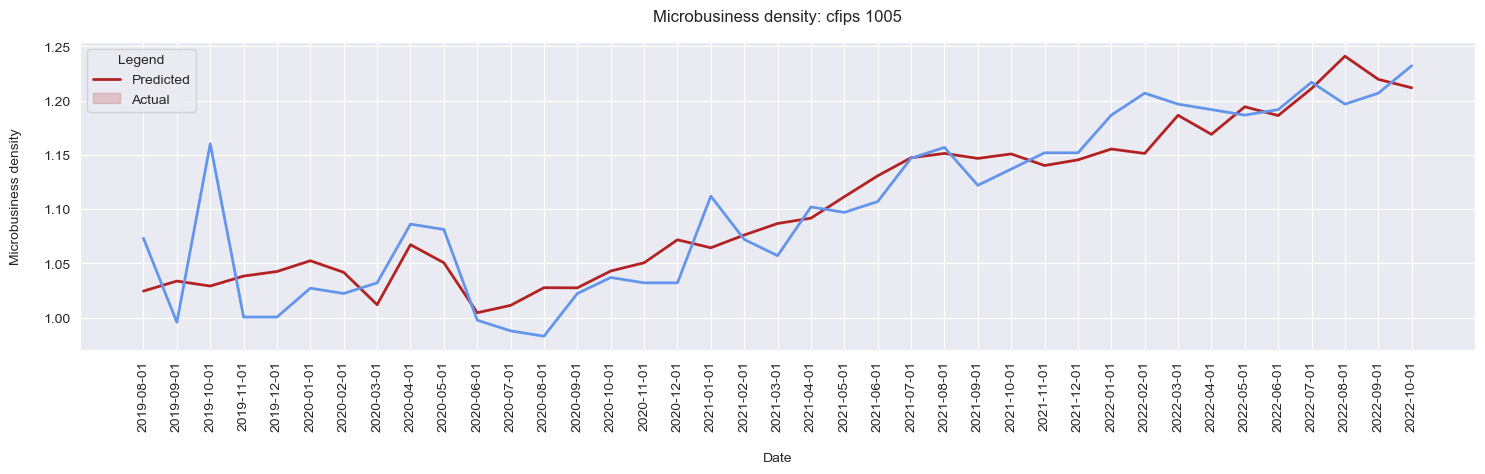

In [134]:
# Plot
fig, ax = plt.subplots(figsize=(18, 4))
ax = sns.lineplot(
    data=ridge_single_forecast_plot_df,
    x='first_day_of_month',
    y='density',
    hue='status',
    linewidth=2,
    palette=['firebrick', 'cornflowerblue']
)

ax.set_title(f'Microbusiness density: cfips {cfips}', pad=15)
ax.set_xlabel('Date', labelpad=15)
ax.set_ylabel('Microbusiness density', labelpad=15)
ax.tick_params(axis='x', rotation=90)
plt.legend(title='Legend', labels=['Predicted', 'Actual'])

plt.show()